In [59]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torch import nn
import wandb
from PIL import Image
import random
import pandas as pd
import numpy as np
import os
import torchaudio
import librosa
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gustavoreis (tropadochatgpt). Use `wandb login --relogin` to force relogin


True

In [3]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

NUM_WORKERS = 0

Using cuda device


In [4]:

class CustomAudioDataset(Dataset):
    '''
    [EN]Custom dataset class, define the dataset and transformations in the data files
    [PT-BR]Classe dataset customizado, define o dataset e as transformações nos arquivos de dados
    '''
    def __init__(self, annotations_file,path_idx,label_idx, base_dir,target_sample_rate ,transform=None, target_transform=None, labe2id = None):
        '''
        [EN] 
        files -> csv file with the metadata of data
        path_idx -> index of file path info in the given csv
        label_idx -> index of label info in the given csv
        base_dir -> base directory to be joined with the given path of files
        sample rate -> target sample rate for the audio data
        transform -> torch transforms to be aplied in the audio
        target transform -> torch transforms to be applied in the label
        label2id -> defining id to labels #improve to be automatic
        [PT-BR]
        files -> arquivo csv com os metadados dos dados
        path_idx -> índice das informações do caminho do arquivo no csv fornecido
        label_idx -> índice de informações do rótulo no csv fornecido
        base_dir -> diretório base a ser associado ao caminho de arquivos fornecido
        sample rate -> sample rate alvo para os dados de áudio
        transform -> transformações torch a serem aplicadas no áudio
        target transform -> transformações torch a serem aplicadas nas labels
        label2id -> definindo id para as labels #melhorar para ser automático
        '''

        self.files = pd.read_csv(annotations_file)
        self.path_idx = path_idx
        self.label_idx = label_idx
        self.base_dir = base_dir
        self.sample_rate = target_sample_rate
        self.transform = transform
        self.target_transform = target_transform
        self.label2id = {'cat':0,'dog':1}

    def get_db_spectogram(self,waveform):
        '''
        [EN]waveform -> wav tensor to convert to spectrogram 
        [PT-BR] waveform -> tensor wav para converter para espectrogram
        '''
        transform = torchaudio.transforms.Spectrogram(n_fft=600)
        masking = torchaudio.transforms.TimeMasking(time_mask_param=80,p=0.25)
        spectrogram = transform(waveform)
        spectrogram = transforms.AmplitudeToDB()(spectrogram)
        spectrogram = masking(spectrogram)
        return spectrogram

    def audio_padding(self, waveform,sr, max_s):
        '''
        [EN]padding wav tensors to be the same length 
        [PT-BR] aplicando padding nos tensores wav para terem o mesmo tamanho
        '''
        max_len = max_s*sr
        n_rows, wav_len = waveform.shape
        if (wav_len/sr) > max_s:
            waveform = waveform[:,:max_len] # trucating
        else:
            #complete the edges of audio with zeros
            pad_begin = random.randint(0,(max_len - wav_len))
            pad_end = max_len -wav_len- pad_begin
            begin_zeros = torch.zeros(n_rows,pad_begin)
            end_zeros = torch.zeros(n_rows,pad_end)
            waveform = torch.cat((begin_zeros, waveform,end_zeros),1)
        
        return waveform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.base_dir, self.files.iloc[idx, self.path_idx])
        waveform, sample_rate = torchaudio.load(audio_path, normalize=True)
        if sample_rate != self.sample_rate:
            transform = transforms.Resample(sample_rate, self.sample_rate)
            waveform = transform(waveform)

        waveform = self.audio_padding(waveform,sample_rate,5)
        spec = self.get_db_spectogram(waveform)

        label = self.files.iloc[idx, self.label_idx]
        label = self.label2id[label]
        if self.transform:
            waveform = self.transform(waveform)
        if self.target_transform:
            label = self.target_transform(label)
        return spec, label
   
    


    
class Data:
    '''
    [EN]Data class, define the dataloader of a dataset object, with a given batch size
    [PT-BR]Classe data, define o dataloader de um objeto dataset, dado um batch size
    '''
    def __init__(self, batch_size,dataset_train,dataset_test):
        self.batch_size = batch_size
        self.training_data = dataset_train
        self.test_data = dataset_test
    
    def get_loader(self, training: bool):
        if training:
            dataloader = DataLoader(self.training_data,batch_size=self.batch_size, shuffle=True)
        else:
            dataloader = DataLoader(self.test_data,batch_size=self.batch_size, shuffle=False)
        return dataloader


In [5]:
class Evaluator:
    '''
    [EN] Evaluator class for loss function
    [PT-BR] Classe de Evaluator do modelo para função de custo
    '''
    def __init__(self):
        self.loss_fn = nn.CrossEntropyLoss()

    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)

In [6]:
print(DEVICE)

cuda


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    '''
    [EN]Defining the model architeture
    [PT-BR] Definindo a arquitetura do modelo
    '''
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1,128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*20*18,256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Linear(32, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.conv_layer(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.linear_relu_stack(x)
        #print(x.shape)
        return x

   
    
class Learner:
    '''
    [EN]Defining the optimizer of model, Adam is used for faster convergence
    [PT-BR]Definindo um otimizadar para o modelo, o Adam é usado para ter uma convergência mais rápida
    '''
    def __init__(self):
        self.model = NeuralNetwork()
        self.model.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-6)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
import time

class Trainer:
    def __init__(self, data: Data, learner: Learner, evaluator: Evaluator):
        '''
        [EN]
        Data object, that contains the dataset and dataloader
        Learner object the model architeture and its optimizer and predict function
        Evaluator object with the loss function and update 
        [PT-BR]
        Objeto Data, que contém o dataset e o dataloader
        Objeto Learner, a arquitetura do modelo e seu otimizador e função de predict
        Objeto Evaluator, contém a função da loss 
        '''
        self.data = data
        self.learner = learner
        self.evaluator = evaluator
        self.best_acc = 0

    def one_epoch(self, training: bool):
        self.learner.model.train(training)
        dataloader = self.data.get_loader(training)
        test_loss, correct = 0, 0
        train_loss = 0
        num_batches = len(dataloader)
        size = len(dataloader.dataset)
        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_hat = self.learner.predict(X)
            loss = self.evaluator.get_loss(y, y_hat)
            if training:
                self.learner.update(loss)
                train_loss += loss.item()
                if batch_idx % 100 == 0:
                    loss, current = loss.item(), (batch_idx + 1) * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                
            else:
                test_loss += loss.item()
                correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()
            
        if not training:
            test_loss /= num_batches
            correct /= size
            test_acc = 100*correct
            print(f"Test Error: \n Accuracy: {test_acc:>0.1f}%, Avg loss: {test_loss:>8f} \n")
            return test_loss, test_acc
        else:
            train_loss /= num_batches
            return train_loss

    def run(self, n_epochs: int):
        wandb.init(project="CatXDogs", entity="gustavoreis")
        for t in range(n_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            #start = time.time()
            train_loss = self.one_epoch(training=True)
            #end = time.time()
            #print(f"time: {end - start:.2f}s")
            with torch.no_grad():
                test_loss, test_acc = self.one_epoch(training=False)
            if test_acc > self.best_acc:
                torch.save(self.learner.model.state_dict(), 'best-model_parameters.pt')
            wandb.log({"Loss/train per epoch": train_loss, "Loss/test per epoch": test_loss, "Accuracy/test": test_acc})
        print("Done!")
        wandb.finish()

In [8]:
dataset_train = CustomAudioDataset('dataset/train.csv',base_dir ='',path_idx=0,label_idx=1,target_sample_rate=16000)
dataset_test = CustomAudioDataset('dataset/test.csv',base_dir = '',path_idx=0,label_idx=1,target_sample_rate=16000)
data = Data(2, dataset_train,dataset_test)

In [9]:
learner = Learner()
evaluator = Evaluator()
trainer = Trainer(data, learner, evaluator)

In [11]:
trainer.run(150)

wandb: Currently logged in as: gustavoreis. Use `wandb login --relogin` to force relogin


Epoch 1
-------------------------------
loss: 0.495740  [    2/  207]
loss: 0.504373  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.751338 

Epoch 2
-------------------------------
loss: 0.715367  [    2/  207]
loss: 0.714323  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.751115 

Epoch 3
-------------------------------
loss: 0.505058  [    2/  207]
loss: 0.505865  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.750688 

Epoch 4
-------------------------------
loss: 0.715166  [    2/  207]
loss: 0.714459  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.750294 

Epoch 5
-------------------------------
loss: 0.714942  [    2/  207]
loss: 0.920271  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.749755 

Epoch 6
-------------------------------
loss: 0.507548  [    2/  207]
loss: 0.919335  [  202/  207]
Test Error: 
 Accuracy: 41.4%, Avg loss: 0.749318 

Epoch 7
-------------------------------
loss: 0.918744  [    2/  207]
loss: 0.917588  [ 

Accuracy/test,▁▁▁▁▁▁▁▁▆▆▆▅▆▅▆▆▅▆▅▇▇▇▇▇████████████████
Loss/test per epoch,███████▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Loss/train per epoch,███████▇▇▇▇▇▇▆▆▆▆▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Accuracy/test,95.71429
Loss/test per epoch,0.15535
Loss/train per epoch,0.15304


Testing

In [34]:
dataset_train = CustomAudioDataset('dataset/train.csv',base_dir ='',path_idx=0,label_idx=1,target_sample_rate=16000)
dataset_test = CustomAudioDataset('dataset/test.csv',base_dir = '',path_idx=0,label_idx=1,target_sample_rate=16000)
data = Data(2, dataset_train,dataset_test)

In [13]:
model_network = Learner()
model_network.model.load_state_dict(torch.load('best-model_parameters.pt'))

<All keys matched successfully>

In [54]:
preds = []
labels = []
with torch.no_grad():
     dataloader = data.get_loader(training=False)
     for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_hat = model_network.predict(X)
            pred = y_hat.argmax(dim=1).tolist()
            labels.extend(y.tolist())
            preds.extend(pred)

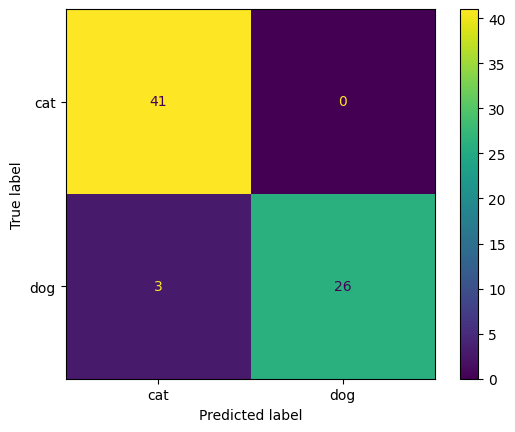

In [61]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat','dog'])
disp.plot()